**xgb와 lgbm은 코랩사용 권장**(jupyter는 로컬이라 라이브러리 작동 잘 안되는듯함)

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import time

from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree  # xgboost의 것과 헷갈리지 말것

import graphviz
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
import os
if os.name == 'nt':
    font_family = 'Malgun Gothic'
elif os.name == 'posix':  # colab 환경
    font_family = "NanumBarunGothic"
else:
    font_family = 'AppleGothic'
sns.set(font = font_family, rc={"axes.unicode_minus":False})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Personal Loan 데이터 불러오기
data = pd.read_csv("/content/drive/MyDrive/2022 데이터 분석 청년인재/smartshelter/성동구 최종 데이터.csv", encoding='cp949')
data.head()

,Unnamed: 0,ARS-ID,버스 총 승차수,쉼터여부,NODE_ID,정류소명,위도,경도,버스 수,버스 노선 리스트,평균 배차 간격,최대 배차 간격,가장 가까운 지하철역,지하철역 최단거리(m),도로명,도로폭,도로폭_숫자,인구
0,0,4001,39270,0,103000001,답십리역사거리,37.565426,127.054368,6,"['9403', '370', '303', 'N30', '721', '130']",13.67,40,답십리,217.156,천호대로,폭8-10m,3,11475
1,1,4002,37286,0,103000002,청년회의소.서울새활용플라자,37.561952,127.060479,9,"['9403', '3216', '2221', '370', '3220', '303',...",13.89,40,장한평,367.819,천호대로,폭8-10m,3,11475
2,2,4003,61371,0,103000003,장한평역,37.561131,127.066098,10,"['9403', '2416', '3216', '2221', '370', '3220'...",14.00,40,장한평,136.266,천호대로,폭8-10m,3,11475
3,3,4101,17969,1,103000004,상왕십리역,37.564279,127.029260,5,"['2012', 'N62', '2014', '2015', '463']",12.80,24,상왕십리,42.408,왕십리로,폭12-15m,5,16320
4,4,4102,35007,1,103000005,상왕십리역,37.564609,127.028642,11,"['302', '2013', '2012', 'N62', '2014', '463', ...",12.18,24,상왕십리,23.403,왕십리로,폭12-15m,5,16320


In [4]:
# 사용하지 않을 변수 제거
data_processed = data.dropna().drop(['Unnamed: 0', 'ARS-ID', 'NODE_ID', '정류소명', '위도', '경도', '버스 노선 리스트', '최대 배차 간격', '가장 가까운 지하철역', '도로명', '도로폭'], axis=1, inplace = False)
data_processed.head()

,버스 총 승차수,쉼터여부,버스 수,평균 배차 간격,지하철역 최단거리(m),도로폭_숫자,인구
0,39270,0,6,13.67,217.156,3,11475
1,37286,0,9,13.89,367.819,3,11475
2,61371,0,10,14.00,136.266,3,11475
3,17969,1,5,12.80,42.408,5,16320
4,35007,1,11,12.18,23.403,5,16320


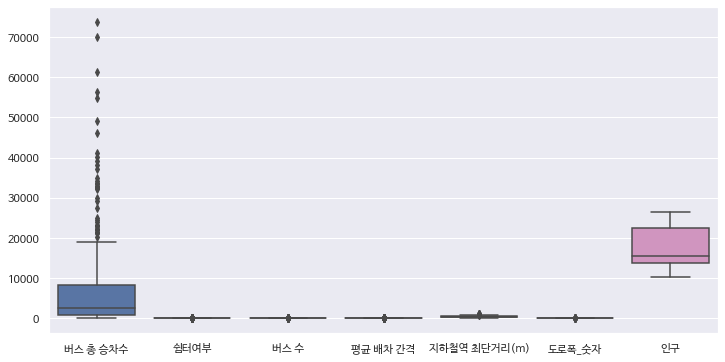

In [5]:
# 박스플롯 확인
plt.figure(figsize=(12, 6))
sns.boxplot(data = data_processed)
plt.show()

In [6]:
print(len(data_processed[data_processed['버스 총 승차수'] > 20000]))
data_processed = data_processed[data_processed['버스 총 승차수'] < 20000]
data_processed.reset_index(inplace=True, drop=True)

36


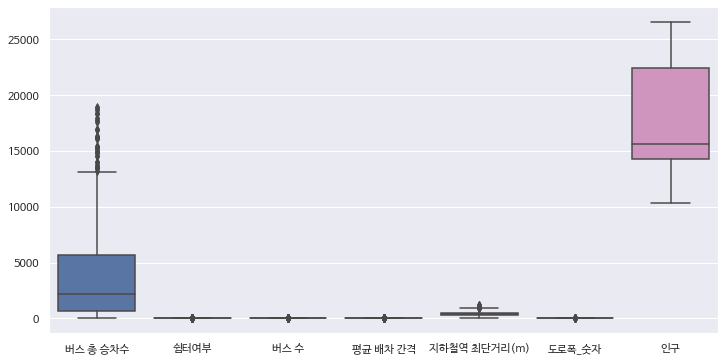

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = data_processed)
plt.show()

In [8]:
Q1 = data_processed['버스 총 승차수'].quantile(q=0.25)
Q3 = data_processed['버스 총 승차수'].quantile(q=0.75)
IQR = Q3 - Q1
print(Q1)
print(Q3)
print(IQR)

672.5
5672.25
4999.75


In [9]:
print(len(data_processed[data_processed['버스 총 승차수'] > (Q3 + IQR * 1.5)]))

30


In [11]:
data_processed = data_processed[['버스 총 승차수', '인구', '평균 배차 간격', '지하철역 최단거리(m)', '버스 수', '도로폭_숫자', '쉼터여부']]
data_processed.head()

,버스 총 승차수,인구,평균 배차 간격,지하철역 최단거리(m),버스 수,도로폭_숫자,쉼터여부
0,17969,16320,12.80,42.408,5,5,1
1,16368,26534,12.18,344.555,11,5,1
2,9614,26534,12.50,503.324,4,1,0
3,5091,16320,9.57,183.693,7,5,0
4,17623,26534,10.25,487.438,4,1,0


In [12]:
# 쉼터여부 분리하여 x,y 지정
feature_columns = data_processed.columns.difference(["쉼터여부"])
X = data_processed[feature_columns]
y = data_processed["쉼터여부"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(316, 6) (80, 6) (316,) (80,)


In [13]:
scaler=MinMaxScaler()
scaler.fit(X_train)  # fit은 train의 데이터셋으만 진행
data_scaled=scaler.transform(X_train)
data_scaled=pd.DataFrame(data=data_scaled, columns=X_train.columns)
X_train = data_scaled
X_train.head()

,도로폭_숫자,버스 수,버스 총 승차수,인구,지하철역 최단거리(m),평균 배차 간격
0,0.000,0.0,0.012702,0.292632,0.355600,0.1250
1,0.375,0.0,0.004975,0.292632,0.121035,0.1250
2,0.000,0.0,0.035565,0.109073,0.257520,0.4375
3,0.000,0.1,0.201694,0.737385,0.711771,0.1875
4,0.000,0.0,0.171368,0.369156,0.514174,0.1875


In [14]:
data_scaled=scaler.transform(X_test)
data_scaled=pd.DataFrame(data=data_scaled, columns=X_test.columns)
X_test = data_scaled
X_test.head()

,도로폭_숫자,버스 수,버스 총 승차수,인구,지하철역 최단거리(m),평균 배차 간격
0,0.000,0.0,0.015242,1.000000,0.277988,0.1875
1,0.250,0.2,0.249696,0.325181,0.593264,0.3750
2,0.000,0.0,0.043609,0.109073,0.309920,0.4375
3,0.250,0.0,0.002699,0.292632,0.315689,0.1250
4,0.375,0.0,0.009156,0.787907,0.324944,0.1250


In [37]:
lgbmc = LGBMClassifier(n_estimators=400, application='binary')
evals = [(X_test, y_test)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbmc.predict(X_test)
preds_proba = lgbmc.predict_proba(X_test)[:, 1]
print(preds_proba)

[1]	valid_0's binary_logloss: 0.239292	valid_0's binary_logloss: 0.239292
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.225569	valid_0's binary_logloss: 0.225569
[3]	valid_0's binary_logloss: 0.21433	valid_0's binary_logloss: 0.21433
[4]	valid_0's binary_logloss: 0.206805	valid_0's binary_logloss: 0.206805
[5]	valid_0's binary_logloss: 0.199777	valid_0's binary_logloss: 0.199777
[6]	valid_0's binary_logloss: 0.191028	valid_0's binary_logloss: 0.191028
[7]	valid_0's binary_logloss: 0.184993	valid_0's binary_logloss: 0.184993
[8]	valid_0's binary_logloss: 0.183299	valid_0's binary_logloss: 0.183299
[9]	valid_0's binary_logloss: 0.180235	valid_0's binary_logloss: 0.180235
[10]	valid_0's binary_logloss: 0.179523	valid_0's binary_logloss: 0.179523
[11]	valid_0's binary_logloss: 0.176517	valid_0's binary_logloss: 0.176517
[12]	valid_0's binary_logloss: 0.174083	valid_0's binary_logloss: 0.174083
[13]	valid_0's binary_logloss: 0.170655	valid_0'

In [22]:
cross_val = cross_validate(
    estimator = lgbmc,
    X = X, y = y,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time: 0.5056069850921631 (+/- 0.7048867386743559)
avg score time: 0.008520174026489257 (+/- 0.006437257664848198)
avg test score: 0.8766139240506329 (+/- 0.07488176334070035)


In [23]:
cut_off = np.linspace(0.01, 0.99, 20)
for c in cut_off:
    preds = [1 if x > c else 0 for x in preds_proba]
    print(f'정확도:{accuracy_score(y_test, preds):0.2f}, 민감도:{recall_score(y_test, preds):0.2f}, 정밀도{precision_score(y_test, preds):0.2f}, cut_off:{c:0.2f}')

정확도:0.74, 민감도:1.00, 정밀도0.22, cut_off:0.01
정확도:0.81, 민감도:1.00, 정밀도0.29, cut_off:0.06
정확도:0.81, 민감도:1.00, 정밀도0.29, cut_off:0.11
정확도:0.84, 민감도:1.00, 정밀도0.32, cut_off:0.16
정확도:0.88, 민감도:1.00, 정밀도0.38, cut_off:0.22
정확도:0.88, 민감도:0.83, 정밀도0.36, cut_off:0.27
정확도:0.91, 민감도:0.83, 정밀도0.45, cut_off:0.32
정확도:0.90, 민감도:0.67, 정밀도0.40, cut_off:0.37
정확도:0.90, 민감도:0.50, 정밀도0.38, cut_off:0.42
정확도:0.90, 민감도:0.33, 정밀도0.33, cut_off:0.47
정확도:0.90, 민감도:0.17, 정밀도0.25, cut_off:0.53
정확도:0.90, 민감도:0.17, 정밀도0.25, cut_off:0.58
정확도:0.93, 민감도:0.00, 정밀도0.00, cut_off:0.63
정확도:0.93, 민감도:0.00, 정밀도0.00, cut_off:0.68
정확도:0.93, 민감도:0.00, 정밀도0.00, cut_off:0.73
정확도:0.93, 민감도:0.00, 정밀도0.00, cut_off:0.78
정확도:0.93, 민감도:0.00, 정밀도0.00, cut_off:0.84
정확도:0.93, 민감도:0.00, 정밀도0.00, cut_off:0.89
정확도:0.93, 민감도:0.00, 정밀도0.00, cut_off:0.94
정확도:0.93, 민감도:0.00, 정밀도0.00, cut_off:0.99


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

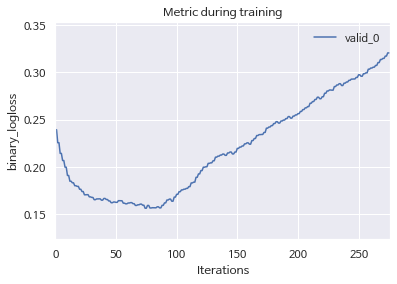

In [18]:
plot_metric(lgbmc)

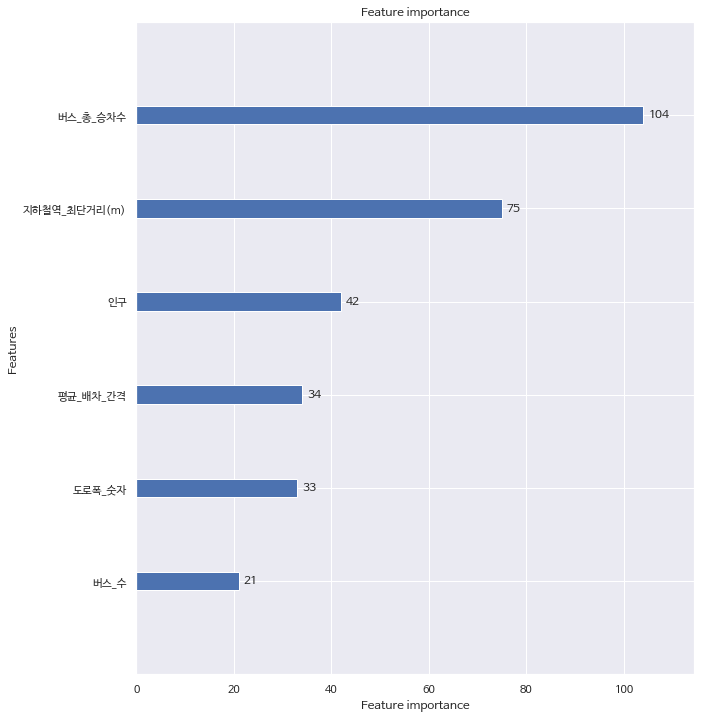

In [19]:
plot_importance(lgbmc, figsize=(10, 12))

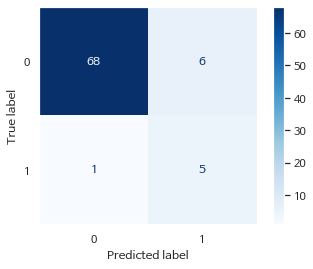

In [24]:
preds = [1 if x > 0.32 else 0 for x in preds_proba]
cm = confusion_matrix(y_test, preds) #confusion_matrix 함수 실행

cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.grid(False)

In [25]:
bupyeong = pd.read_csv('/content/drive/MyDrive/2022 데이터 분석 청년인재/smartshelter/부평구 최종 데이터.csv', encoding='cp949')
bupyeong_copy = bupyeong.copy()
bupyeong.head(1)

,Unnamed: 0,정류소명,정류소아이디,정류소주소,노선아이디,정류소번호,노선번호,평균 배차 간격,최대 배차 간격,도로명,...,도로폭_숫자,버스수,권역,승차건수(총합계),행정동,경도,위도,인구수,가장 가까운 지하철역,지하철역 최단거리(m)
0,0,진산과학고등학교,166000915,인천광역시 부평구 굴포로 208 버스정류장,165000112,40915,"['565', '555', '558']",13.33,17,굴포로,...,9.0,3,부평구,67,삼산2동,126.744259,37.513589,28818,삼산체육관,806.438


In [26]:
# 사용하지 않을 변수 제거 
bupyeong = bupyeong.dropna().drop(['Unnamed: 0', '정류소명', '정류소주소', '정류소아이디', '노선아이디', '정류소번호', '노선번호', '최대 배차 간격', '도로명', '도로폭', '권역', '행정동', '경도', '위도', '가장 가까운 지하철역'], axis=1, inplace = False)
bupyeong.head()

,평균 배차 간격,도로폭_숫자,버스수,승차건수(총합계),인구수,지하철역 최단거리(m)
0,13.33,9.0,3,67,28818,806.438
1,13.00,8.0,2,7115,33290,1218.165
2,23.00,10.0,8,4730,14921,416.958
3,16.00,7.0,3,295,14975,598.883
4,24.00,8.0,1,164,13933,1208.172


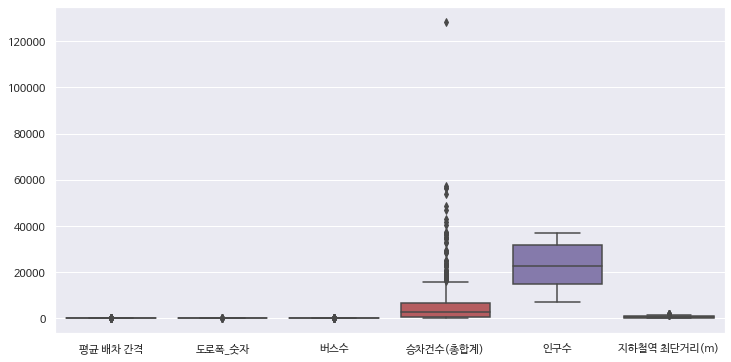

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = bupyeong)
plt.show()

In [28]:
# 데이터프레임 열이름 변경
bupyeong.columns=['평균 배차 간격', '도로폭_숫자', '버스 수', '버스 총 승차수', '인구', '지하철역 최단거리(m)']
bupyeong.head()

,평균 배차 간격,도로폭_숫자,버스 수,버스 총 승차수,인구,지하철역 최단거리(m)
0,13.33,9.0,3,67,28818,806.438
1,13.00,8.0,2,7115,33290,1218.165
2,23.00,10.0,8,4730,14921,416.958
3,16.00,7.0,3,295,14975,598.883
4,24.00,8.0,1,164,13933,1208.172


In [29]:
bupyeong = bupyeong[['도로폭_숫자', '버스 수', '버스 총 승차수', '인구', '지하철역 최단거리(m)', '평균 배차 간격']]
bupyeong.head()

,도로폭_숫자,버스 수,버스 총 승차수,인구,지하철역 최단거리(m),평균 배차 간격
0,9.0,3,67,28818,806.438,13.33
1,8.0,2,7115,33290,1218.165,13.00
2,10.0,8,4730,14921,416.958,23.00
3,7.0,3,295,14975,598.883,16.00
4,8.0,1,164,13933,1208.172,24.00


In [30]:
bupyeong_scaled=scaler.transform(bupyeong)
bupyeong_scaled=pd.DataFrame(data=bupyeong_scaled, columns=bupyeong.columns)
bupyeong_scaled.head()

,도로폭_숫자,버스 수,버스 총 승차수,인구,지하철역 최단거리(m),평균 배차 간격
0,1.000,0.2,0.003281,1.141066,0.678237,0.395625
1,0.875,0.1,0.376290,1.417269,1.034106,0.375000
2,1.125,0.7,0.250066,0.282750,0.341598,1.000000
3,0.750,0.2,0.015348,0.286085,0.498841,0.562500
4,0.875,0.0,0.008415,0.221728,1.025468,1.062500


In [32]:
bupyeong_predicts_proba = np.round(lgbmc.predict_proba(bupyeong_scaled)[:, 1], 3) # 1로 분류할 확률을 3자리수까지 반올림하여 표현
print(bupyeong_predicts_proba[:10])

[0.006 0.408 0.029 0.003 0.005 0.006 0.041 0.002 0.041 0.002]


In [33]:
bupyeong_preds = [1 if x > 0.32 else 0 for x in preds_proba]
print(bupyeong_preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [34]:
bupyeong['쉼터 설치 적합도'] = bupyeong_predicts_proba
bupyeong['버스정류장'] = bupyeong_copy['정류소명']
bupyeong['정류장번호'] = bupyeong_copy['정류소번호']
bupyeong.head()

,도로폭_숫자,버스 수,버스 총 승차수,인구,지하철역 최단거리(m),평균 배차 간격,쉼터 설치 적합도,버스정류장,정류장번호
0,9.0,3,67,28818,806.438,13.33,0.006,진산과학고등학교,40915
1,8.0,2,7115,33290,1218.165,13.00,0.408,삼산주공1단지(상가앞),40908
2,10.0,8,4730,14921,416.958,23.00,0.029,희망체육공원입구,40912
3,7.0,3,295,14975,598.883,16.00,0.003,인천성모병원종점지주차장,40919
4,8.0,1,164,13933,1208.172,24.00,0.005,열우물보조경기장주차장,40916


In [35]:
result = bupyeong.sort_values('쉼터 설치 적합도', ascending=False)

In [36]:
result.head(20)

,도로폭_숫자,버스 수,버스 총 승차수,인구,지하철역 최단거리(m),평균 배차 간격,쉼터 설치 적합도,버스정류장,정류장번호
581,5.0,7,56613,12746,116.816,13.86,0.739,백운역,40081
130,5.0,4,10986,12746,88.228,15.25,0.725,백운역,40716
506,9.0,3,7299,12565,671.839,10.33,0.712,일신동행정복지센터,40200
212,7.0,2,6050,35302,993.827,10.00,0.677,로얄금속,40599
370,9.0,2,6564,31745,918.456,10.00,0.677,부흥오거리(부흥아파트),40394
68,9.0,4,5688,12565,874.176,12.75,0.631,군수사령부입구(장애인복지관),40825
21,7.0,6,6874,12565,814.119,19.83,0.631,풍림아파트104동,40898
63,9.0,4,6836,12565,1217.394,21.00,0.631,금마초등학교,40833
36,7.0,6,5911,12565,728.544,19.83,0.629,일신주공109동,40868
379,8.0,5,6544,17762,880.507,10.00,0.614,KT부평지사,40384


공식문서에 따르면 일반적으로 10000건 이하의 데이터를 다루는 경우에는 과적합 문제가 발생하기 쉽다고 한다. 이거 쓰는건 나중에 한번 고려해봐야 할 것 같음